# Social Network Analysis group project 📊

***

## Group members 👥
- Michele Turco
- Simone Filosofi
- Edoardo Cocciò
- Lorenzo Laterza

# General Introduction



The graph we have choosen is "Forrest Gump (movie) network". 

This graph is undirected and weighted.
Nodes are characters and the link represent a same-scene appearance between two characters in the movie,
and the weight gives the number of same-scene appearances.

Source: J. Kaminski et al., "Moviegalaxies - Social Networks in Movies." 


# Importing libraries  

In [1]:
import networkx as nx # this is for network analysis
import pandas as pd # this is for data analysis
import matplotlib.pyplot as plt # this is for plotting
import json # this is for reading json files

# 1) Week 1

a) Implement it in Python.

b) Draw the graph

c) Compute the number of nodes,edges, average degree and the density. Comment.

# Reading the input file

In [2]:
nodes_df = pd.read_csv('data/nodes.csv', index_col=0,sep = ',')
edges_df = pd.read_csv('data/edges.csv')
nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads) # replace single quotes with double quotes and convert to dict

nodes_df['size'] = nodes_df[' viz'].apply(lambda row: row['size'] * 100) # multiply by 100 to make the visualization of the nodes better
nodes_df[' _pos'] = nodes_df[' _pos'].apply(lambda row: (float(row[7:18]), float(row[20:-2]))) # convert string to tuple containing x and y coordinates


# a) Implementing the graph

In [3]:
G = nx.Graph()

links = edges_df.apply(lambda row: (row['# source'], row[' target'], row[' weight']), axis=1) 
links = list(links)  # The edges of the Graph are stored in a list of tuples containing the source, target and weight of the edge

labels = enumerate(nodes_df[' label'])
labels = dict(labels)

pos = nodes_df[' _pos'] 

colors = []
for n in range(0, len(nodes_df)):
    color = nodes_df[' viz'][n]['color']
    accepted_format = (color['r']/255, color['g']/255, color['b']/255, color['a'])
    colors.append(accepted_format)
    G.add_node(n)

G.add_weighted_edges_from(links)
nx.set_node_attributes(G, labels, name = 'label')


# b) Draw the graph

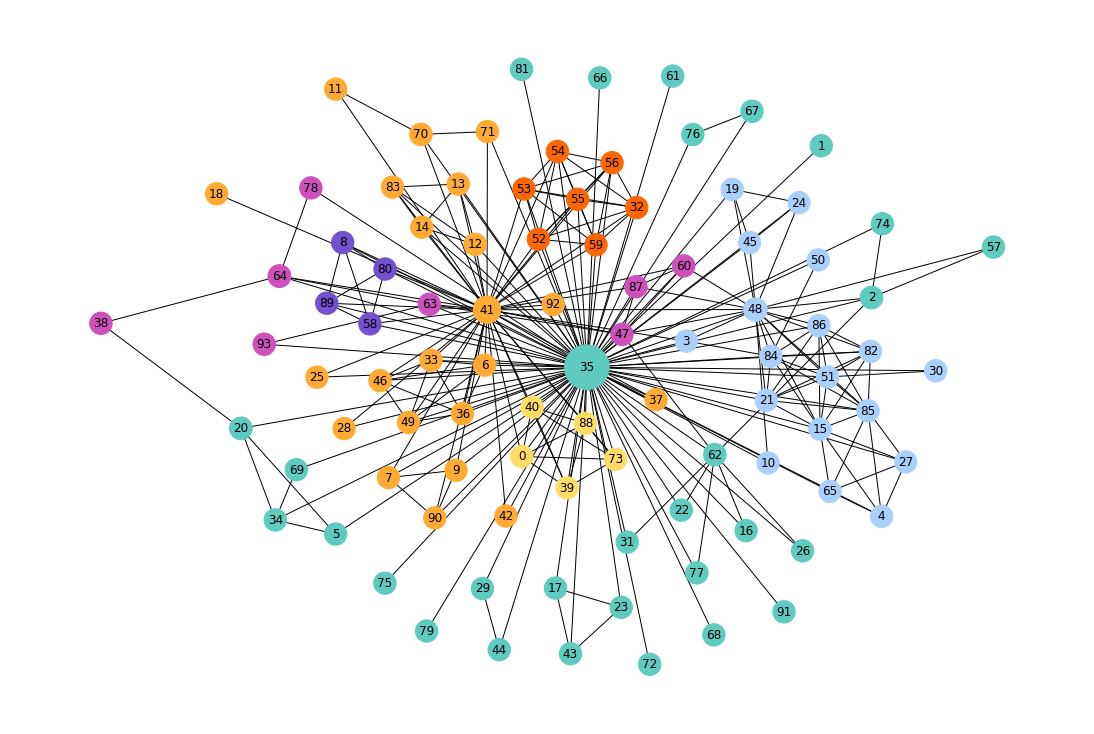

In [4]:
plt.figure(figsize=(15, 10))


nx.draw(G, node_size = nodes_df['size'], pos = pos, with_labels = True, node_color = colors)

# c) Compute:

### - Number of nodes

In the film appear 94 characters, so the number of nodes is 94.

In [5]:
N = G.number_of_nodes()
print("Number of nodes: ", N)

Number of nodes:  94


### - Number of edges

In [6]:
E = G.number_of_edges()
print("Number of edges: ", E)

Number of edges:  271


### - Average degree


In [7]:
Average_degree = 2 * E / N
print("Average degree: ", Average_degree)

Average degree:  5.76595744680851


### - Density

The density is very low (0.06199954243880119). 

It means that here are relatively few edges compared to the total number of possible edges in the graph. Not all the characters interact with each other.


In [8]:
density = Average_degree/(N - 1)
print("Density: ", density)

Density:  0.06199954243880119


# 2) Week 2

While considering the largest component of your network.

a) Compute Average clustering and Transitivity number

b) Implement a function computing the transitivity using basic function of networkx

# Checking what's the largest component of the graph
Since all nodes are connected we are considering the entire graph for the following computations. The first function is used to check if the graph is connected.

In [9]:
cc = [i for i in nx.connected_components(G)] # list of connected components
len(cc) # number of connected components

1

### Diameter

In [10]:
nx.diameter(G) # the maximum distance between two nodes iinside the graph

4

### Average Shortest Path Length

In [11]:
nx.average_shortest_path_length(G)

1.9949668268130862

# a) Average Clustering

In [12]:
nx.average_clustering(G)

0.8002425574908809

# b) Transitivity implementation using basic networkx functions

To compute the **transitivity** _t_:
$$T = \frac{3(\#triangles)}{\sum\limits_{i}\frac{K(i)(K(i)-1)}{2}}$$
where $\sum\limits_{i}\frac{K(i)(K(i)-1)}{2}$ is the number of wedges in the graph.


The first function in the following block is used to count the number of triangles in the graph. It iterates over all the nodes and for each of them it stores their neighbours. Then it checks if there are edges between the neighbours. If there are, it means that there is a triangle.  
The second function is used to compute the transitivity. It uses the number of triangles computed in the previous function and the number of wedges stored in the variable denominator.

In [13]:
def count_triangles(G):
    "Count the number of triangles in the graph without using nx.triangles "
    triangles = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                u, v = neighbors[i], neighbors[j]
                if (u,v) in G.edges():
                    triangles += 1
    return triangles   # Each triangle is counted 3 times (once for each node)

def transitivity(G):
# Actual number of triangles is 'triangles'/3, but the denominator semplifies with the '3' in the main formula

    triangles = count_triangles(G) # number of triangles inside the graph
    denominator = 0 # denominator of the formula

    for node in G.nodes():
        fraction = (G.degree(node) * (G.degree(node) - 1))/2 # number of wedges
        denominator += fraction

    return triangles / denominator

print(f"Transitivity results:\n---------------------------------------  \nOur implementation: {transitivity(G)} \nNetworkx: {nx.transitivity(G)}")


Transitivity results:
---------------------------------------  
Our implementation: 0.1918081918081918 
Networkx: 0.1918081918081918


# 3) Week 3

Depending on what seems more relevant in your graph, pick one of the following local notions:
- Decay centrality 
- Betweeness centrality 
- Closeness centrality 
- Clustering
- Any other notions that you invent

a) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").

b) Discuss why you picked this measure and who is the most central in your network based on your choice.

c) Provide the cumulative distribution for this centrality and give a graphical representation of your graph (log-log, log or normal representation as you think it is more relevant).

# a) Closeness centrality 


To compute the **closeness centrality of node** _i_:
$$g_{i} = \frac{1}{\sum\limits_{i \ne j}\ell(i,j)}$$
where $\ell(i,j)$ is the distance (shortest path) between the two nodes.

To get a more relevant result we computed the **normalized closeness centrality**:
$$C_{i}^{clo} = g_{i}\cdot (N-1) = \frac{N - 1}{\sum\limits_{i \ne j}\ell(i,j)}$$  




The following block contains the functions used to compute the lenght of the shortest path between two nodes, that is needed to compute the closeness centrality.  
The first function **shortest_path** returns the shortest path between two nodes and its lenght. However, it firstly checks if there is an edge between the two nodes (and returns the path of lenght 1) and if the two nodes are the same (and returns the path of lenght 0). At each iteration, the function checks if the target node is a neighbor of the last node in the current path. If it is, the path is returned. Otherwise, the function adds to the list of path all the paths that can be obtained by adding a neighbor of the last node in the current path. If no path is found, the function returns an empty list (note that this is not the case being the graph taken into account connected).  
The second function **shortest_path_length** returns the lenght of the shortest path between two nodes. It uses the first function to get the path and then returns its lenght. The results are stored in a dictionary having the target node as a key and the length of the shortest path as value.

In [14]:
def shortest_path(graph, start, target):
    # If the starting node is equal to the target the shortest path between the two is zero
    if start == target:
        return ([], 0)
    # If there is a direct link between the two nodes the shortest path is one
    if (start, target) in graph.edges():
        return ([target], 1)
    
    
    path_list = [[start]]     # List of paths to be explored
    path_index = 0            # Index of the path to be explored
    previous_nodes = {start}  # To keep track of previously visited nodes

     
    while path_index < len(path_list):
        current_path = path_list[path_index] # Current path
        last_node = current_path[-1]         # Last node in current path
        next_nodes = graph[last_node]        # Nodes connected to last node
        # Search target node
        if target in next_nodes:
            current_path.append(target)
            return (current_path[1:], len(current_path)-1)
        # Add new paths
        for next_node in next_nodes:
            if next_node not in previous_nodes: 
                new_path = current_path[:] # Copy current path
                new_path.append(next_node) # Add next node
                path_list.append(new_path) # Add new path to path_list
                
                previous_nodes.add(next_node) # Add next node to previous_nodes
        # Continue to next path in list
        path_index += 1
    
    
    # In case no path is found
    return ([], -1)

def lenght_shortest_path(graph, start):

    spl = dict()

    for node in graph.nodes():
            spl[node] = shortest_path(G,start,node)[1]

    return spl

print(f"Shortest path results:\n---------------------------------------  \nOur implementation: {sorted(lenght_shortest_path(G, 0).items())} \nNetworkx: {sorted(nx.shortest_path_length(G, 0).items())}")
print(f"Sum of shortest path results:\n---------------------------------------  \nOur implementation: {sum(lenght_shortest_path(G, 44).values())} \nNetworkx: {sum(nx.shortest_path_length(G, 44).values())}")


Shortest path results:
---------------------------------------  
Our implementation: [(0, 0), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, 1), (36, 2), (37, 2), (38, 3), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (55, 2), (56, 2), (57, 3), (58, 2), (59, 2), (60, 2), (61, 2), (62, 2), (63, 2), (64, 2), (65, 2), (66, 2), (67, 2), (68, 2), (69, 2), (70, 2), (71, 2), (72, 2), (73, 1), (74, 2), (75, 2), (76, 2), (77, 2), (78, 2), (79, 2), (80, 2), (81, 2), (82, 2), (83, 2), (84, 2), (85, 2), (86, 2), (87, 2), (88, 1), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2)] 
Networkx: [(0, 0), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8

# b) Discussion on the choice of picking the Closeness centrality
We chose to calculate this centrality measure because it is a relevant metric to highlight interconnectedness and prominence of different elements within our dataset, offering valuable insights about the relationships of characters. In the context of character interaction, closeness centrality helps us to identify which characters are central to the storyline and have close ties with other characters.

More specifically we chose to calculate the closeness centrality of `node 35`(Forrest) and `node 41`(Jenny) as they are the most visible nodes that also have the highest number of links (check the representation of the graph).

In [15]:
# This function trivially applies the formula of the closeness centrality using the values that we previously computed 

def normalized_closeness_centrality(graph, node):
    return (len(graph.nodes()) - 1) / sum(lenght_shortest_path(graph, node).values())

print(f"Centrality of node 35 (Forrest) is: {normalized_closeness_centrality(G, 35)}")
print(f"Centrality of node 41 (Jenny) is: {normalized_closeness_centrality(G,41)}")

Centrality of node 35 (Forrest) is: 0.9587628865979382
Centrality of node 41 (Jenny) is: 0.6595744680851063


# Interpreting the closeness centrality results 🔍

- For node 35, with a centrality of approximately **0.949**, this suggests that it is **highly central within the network**. Nodes with high centrality values like this one often have shorter average distances to all other nodes, meaning they are well-connected and can efficiently communicate or interact with a large portion of the network. As expected, this node plays a crucial role in the network's overall structure and information flow because it is the protagonist of the film: Forrest.

- On the other hand, for node 41 (which is Jenny, Forrest's wife), with a centrality of approximately **0.655**, it also holds a **relatively high** centrality value, indicating that it is important within the network, although not as central as Forrest. This node has meaningful connections and interactions within the network but is not as influential as node 35. It still plays a significant role in the network's structure and communication pathways.

# c) Cumulative distribution function

$$F(x) = P(X \ge x)$$  

The following block contains the code used to compute the cumulative (tail) distribution function of the closeness centrality. It firstly stores in a list the closness centrality for each node and it sorts them in ascending order. Then, it computes the cumulative distribution function for each value of the list by checking how many values are greater than or equal to the current one. Finally, it returns the list of values and the list of probabilities.

[1.0, 0.9893617021276596, 0.9787234042553191, 0.9680851063829787, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5, 0.5, 0.5, 0.5, 0.5, 0.44680851063829785, 0.44680851063829785, 0.44680851063

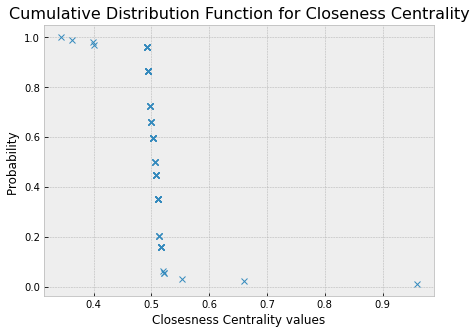

In [16]:

data_closeness_centrality = []
for node in G.nodes():
    data_closeness_centrality.append(normalized_closeness_centrality(G,node))
data_closeness_centrality.sort() 
number_of_nodes = len(data_closeness_centrality)

cdf_x = data_closeness_centrality
cdf_y = []  

for x in cdf_x: 
    y=sum(variable>=x for variable in data_closeness_centrality)/number_of_nodes # count how many elements are bigger than x and divide by the total number of elements
    cdf_y.append(y) 
print(cdf_y)

plt.figure(figsize = (7,5))
plt.style.use('bmh')
plt.title('Cumulative Distribution Function for Closeness Centrality', fontsize = 16)

plt.xlabel('Closesness Centrality values')
plt.ylabel('Probability ')
plt.plot(cdf_x,cdf_y,"x")



# Discussion on the graphical representation
- Being the dataset relatively small, we chose to represent the cumulative distribution function of the closeness centrality using a **normal scale**. This choice allows us to better visualize the distribution of the values and the probability of each value.  

# Interpreting the cdf 🔍

- The cumulative distribution function of the closeness centrality shows that **most of the nodes** have a **low/medium centrality** value: most of the nodes have indeed a centrality value between 0.2 and 0.5. This feauture could be predicted since the nodes represent characters in a film and it is reasonable to assume that most of them have a similar importance in the story, but not all of them are central to the plot and interconnected.
- On the other hand, the **few nodes** that have a **high centrality** value are **very central** to the network. This is the case of node 35 (Forrest) and node 41 (Jenny), which have a centrality value of approximately 0.949 and 0.655 respectively. This is not surprising since these nodes are the most visible ones in the graph and they have the highest number of links (check the representation of the graph).

 # 4) Week 5

a) We write a function for PageRank without using ani NetworkX built-in function;

b) We run it using alpha = 0.15, saving the number of iterations needed and checking that the our result is the same of the one given by the built-in function;

c) Indentify the node with the highest PageRank and compare it with the one we got from Week 3;

d) Cumulative distibution and compare it with the one from Week 3;

e) (optinal) we re-run the PageRank using alpha= 0.5, saving the total number of iterations and compare with the results of point (b).

# a) Our PageRank function

In [17]:
# with 'if all(abs(new_r[node] == r[node])  for node in G.nodes())' --> 95 iterations


alpha = 0.15
def OurPageRank(alpha, G):
    const = alpha / len(G.nodes()) # Compute the constant that will be added to the PageRank of each node
    beta = 1 - alpha # For simplicity, we compute beta so we don't have to compute 1 - alpha every time
    r = {node: 1 / len(G.nodes()) for node in G.nodes()} # Initialize the PageRank of each node to 1/N
    iterations = 0 # At the beginning, we have performed 0 iterations

    for i in range (100): # Perform 100 iterations --> I don't know how to stop the loop when the values converge
        iterations += 1 # Count the number of iterations
        new_r = {} # Create a new dictionary to store the new PageRank values
        for node in G.nodes():
            pr = const # Add the constant at hte beginning of the formula
            for neighbor in G.neighbors(node): # For each neighbor of the node
                pr += beta * (r[neighbor] / len(list(G.neighbors(neighbor))))  # Add the PageRank of each neighbor
            new_r[node] = pr # Update the PageRank of the node
        if all(abs(new_r[node] == r[node])  for node in G.nodes()):  # Check for convergence and stop the loop if it's reached
            break 
        r = new_r  # Now, 'r' contains the PageRank values for each node
    return r, iterations # Return the PageRank values and the number of iterations





In [18]:
# with 'if all(abs(new_r[node] - r[node]) < 0.001  for node in G.nodes())' --> 10 iterations

alpha = 0.15
def OurPageRank(alpha, G):
    const = alpha / len(G.nodes()) # Compute the constant that will be added to the PageRank of each node
    beta = 1 - alpha # For simplicity, we compute beta so we don't have to compute 1 - alpha every time
    r = {node: 1 / len(G.nodes()) for node in G.nodes()} # Initialize the PageRank of each node to 1/N
    iterations = 0 # At the beginning, we have performed 0 iterations

    for i in range (100): # Perform 100 iterations --> I don't know how to stop the loop when the values converge
        iterations += 1 # Count the number of iterations
        new_r = {} # Create a new dictionary to store the new PageRank values
        for node in G.nodes():
            pr = const # Add the constant at hte beginning of the formula
            for neighbor in G.neighbors(node): # For each neighbor of the node
                pr += beta * (r[neighbor] / len(list(G.neighbors(neighbor))))  # Add the PageRank of each neighbor
            new_r[node] = pr # Update the PageRank of the node
        if all(abs(new_r[node] - r[node]) < 0.001  for node in G.nodes()):  # Check for convergence and stop the loop if it's reached
            break 
        r = new_r  # Now, 'r' contains the PageRank values for each node
    return r, iterations # Return the PageRank values and the number of iterations

In [19]:
# I tried to implement the PageRank algorithm using the formula provided in the slides
# It seems to work, but if Iimplement it in the function above it doesn't work anymore !!!

const = alpha/len(G.nodes())
beta = 1-alpha
r = {node: 1 / len(G.nodes()) for node in G.nodes()}
for i in range(100):
    r = {node: const + beta * sum(r[node] / G.degree(node) for node in list(G.neighbors(node))) for node in G.nodes()}
print(r)

{0: 0.010422653081637367, 1: 0.0031317330357600605, 2: 0.010379957246603726, 3: 0.007233602862047269, 4: 0.008708961695658058, 5: 0.007115154133520438, 6: 0.010422653081637367, 7: 0.007854753047031059, 8: 0.009217312249067059, 9: 0.007854753047031059, 10: 0.004498506128509049, 11: 0.004747293096969945, 12: 0.009217312249067059, 13: 0.009217312249067059, 14: 0.009217312249067059, 15: 0.01692823442183343, 16: 0.004923223737742451, 17: 0.007227076236369369, 18: 0.0029804946471338615, 19: 0.007823488919146172, 20: 0.009422558322871264, 21: 0.01246983484631408, 22: 0.004923223737742451, 23: 0.007227076236369369, 24: 0.007823488919146172, 25: 0.004516483002042858, 26: 0.004923223737742451, 27: 0.008708961695658058, 28: 0.004516483002042858, 29: 0.005446492236104453, 30: 0.004486693398093669, 31: 0.004923223737742451, 32: 0.012459263453911336, 33: 0.010422653081637367, 34: 0.00932295272541287, 35: 0.16082701598458907, 36: 0.010422653081637367, 37: 0.004516483002042858, 38: 0.00539702940030629

In [20]:
print(f'Our implementation result is: {OurPageRank(0.15, G)}')
#print( f'NetworkX built-in function result is: {nx.pagerank(0.15,G)}') # i have to aggiustare questo che da errore


Our implementation result is: ({0: 0.010415759662207116, 1: 0.003126613024278452, 2: 0.010349131433927898, 3: 0.007208743607352811, 4: 0.008676037903672194, 5: 0.007152681569936712, 6: 0.010415759662207116, 7: 0.00785296842710319, 8: 0.00921673438114669, 9: 0.00785296842710319, 10: 0.004487972111651408, 11: 0.004743675693967999, 12: 0.00921673438114669, 13: 0.00921673438114669, 14: 0.00921673438114669, 15: 0.016857889817036325, 16: 0.004901164364958025, 17: 0.0072593557081250095, 18: 0.0029746864704551625, 19: 0.007818815354592354, 20: 0.00946959418807275, 21: 0.012416137732221328, 22: 0.004901164364958025, 23: 0.0072593557081250095, 24: 0.007818815354592354, 25: 0.004505554813882551, 26: 0.004901164364958025, 27: 0.008676037903672195, 28: 0.004505554813882551, 29: 0.005453376241552406, 30: 0.0044743495390697306, 31: 0.004901164364958025, 32: 0.01240342736740048, 33: 0.010415759662207116, 34: 0.009393241763621378, 35: 0.16143181903049106, 36: 0.010415759662207116, 37: 0.004505554813882

In [28]:
#result = nx.pagerank(0.15,G)
#print( f'NetworkX built-in function result is: {result}')

# c) Node with the highest Pagerank

In [30]:
def highest_pagerank(): # This function returns the node with the highest PageRank
    for node in r.keys(): # For each node in the dictionary
        if r[node] == max(r.values()): # If the PageRank of the node is equal to the maximum PageRank
            return node # Return the node
print(f'The node with the highest PageRank is: {highest_pagerank()}') #COME FACCIO A FAR PRINTARE IL NOME DEL NODO E NON IL NUMERO?

The node with the highest PageRank is: 35


## Considerations on the result and comparisons with Week 3

The node with the highest Pagerank is Forrest (node 35) and it was also the most central node with respect to the Closeness centrality we calculated in Week 3. 

Considerations: 

# d) Cumulative distribution

[1.0, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.9893617021276596, 0.8936170212765957, 0.8829787234042553, 0.8723404255319149, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8085106382978723, 0.7978723404255319, 0.7872340425531915, 0.776595744680851, 0.7659574468085106, 0.7659574468085106, 0.7659574468085106, 0.7659574468085106, 0.7659574468085106, 0.7127659574468085, 0.7021276595744681, 0.6914893617021277, 0.6808510638297872, 0.6808510638297872, 0.6808510638297872, 0.6808510638297872, 0.6382978723404256, 0.6276595744680851, 0.6170212765957447, 0.6170212765957447, 0.6170212765957447, 0.5851063829787234, 0.574468085106383, 0.574468085106383, 0.574468085106383, 0.5425531914893617, 0.5425531914893617, 0.5425531914893617, 0.5106382978723404, 0.5, 0.5, 0.5, 0.46808510638297873, 0.46808510638297873, 0.44680851063829785, 

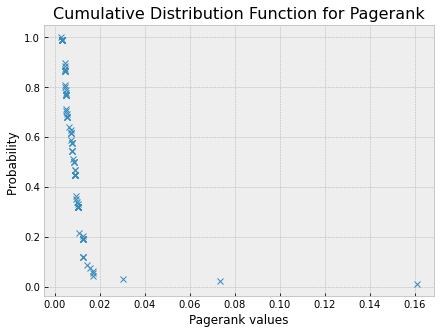

In [32]:
data_pagerank = [] # Create a list to store the PageRank values
for node in G.nodes(): # For each node in the graph
    data_pagerank.append(r[node]) # Add the PageRank of the node to the list
data_pagerank.sort() # Sort the list
number_of_nodes = len(data_pagerank) # Count the number of nodes

cdf_x = data_pagerank  # Create a list containing the PageRank values
cdf_y = []          # Create a list to store the cumulative distribution function values

for x in cdf_x:   # For each PageRank value
    y=sum(variable>=x for variable in data_pagerank)/number_of_nodes # Count how many elements are bigger than x and divide by the total number of elements
    cdf_y.append(y)  # Add the value to the list
print(cdf_y) 

plt.figure(figsize = (7,5))     # Create a new figure
plt.style.use('bmh')           # Use the 'bmh' style
plt.title('Cumulative Distribution Function for Pagerank', fontsize = 16) # Set the title

plt.xlabel('Pagerank values') # Set the label of the x axis
plt.ylabel('Probability ') # Set the label of the y axis
plt.plot(cdf_x,cdf_y,"x") # Plot the cumulative distribution function

# e) Re-run the PageRank using = 0.5

We call again 'OurPageRank' function but giving a different value to alpha (0.5) to compare the new result with the previous one.

In [33]:
print(f'Our implementation result is: {OurPageRank(0.5, G)}')

Our implementation result is: ({0: 0.009874438169139571, 1: 0.006010903192313999, 2: 0.011181079019907697, 3: 0.007818280774539563, 4: 0.009012105410571836, 5: 0.00868965835600131, 6: 0.009874438169139571, 7: 0.008778885395513442, 8: 0.009405810663250892, 9: 0.008778885395513442, 10: 0.006599068508268176, 11: 0.007095469371153665, 12: 0.009405810663250894, 13: 0.009405810663250894, 14: 0.009405810663250894, 15: 0.013181697535312736, 16: 0.0070485663693524315, 17: 0.009027081228269215, 18: 0.0058867231820089036, 19: 0.008804694624996333, 20: 0.010747260468353574, 21: 0.010422627632776444, 22: 0.0070485663693524315, 23: 0.009027081228269215, 24: 0.008804694624996333, 25: 0.00657847743815269, 26: 0.0070485663693524315, 27: 0.009012105410571836, 28: 0.00657847743815269, 29: 0.00802151394784634, 30: 0.006681181063554627, 31: 0.0070485663693524315, 32: 0.010526783038720866, 33: 0.009874438169139571, 34: 0.010657432644455025, 35: 0.124266555553906, 36: 0.009874438169139571, 37: 0.006578477438

Considerations on the different results:

Considerations on the new number of iterations: